`llama-like vs llama-like with triton vs compiled llama-like with triton`

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
torch.set_float32_matmul_precision('high')

## Hyperparameters and Configuration

In [3]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 32
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 1024
EPOCHS = 20
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 2
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [4]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [5]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [6]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [7]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [8]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [9]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 64])
Target shape: torch.Size([1024, 64])
Sample 1: ------------------------------
Input sequence : so set histeeth and tear it; O, I warrant it, how he mammocked
Target sequence: o set histeeth and tear it; O, I warrant it, how he mammockedi

Sample 2: ------------------------------
Input sequence : he's the chosen of Signior Hortensio.TRANIO:Softly, my master
Target sequence: e's the chosen of Signior Hortensio.TRANIO:Softly, my masters

Sample 3: ------------------------------
Input sequence : at from my soul I love thy daughter.QUEEN ELIZABETH:My daught
Target sequence: t from my soul I love thy daughter.QUEEN ELIZABETH:My daughte



## Training Function

In [10]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [11]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [12]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = [] # 에포크별 평균 VRAM 사용량 리스트로 변경 가능 또는 배치별 VRAM 사용량 리스트 유지
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        # Training phase
        # epoch_train_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_train_losses_list, step, epoch_vram_usage_list = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses_list)
        if epoch_vram_usage_list: # CUDA 사용 시에만 vram_usage가 채워짐
             all_vram_usages.extend(epoch_vram_usage_list) # 배치별 VRAM 사용량 모두 저장

        # 현재 에포크의 평균 훈련 로스 계산
        avg_epoch_train_loss = 0
        if epoch_train_losses_list:
            avg_epoch_train_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_train_losses_list])
        
        # Validation phase
        # epoch_val_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_val_losses_list = validate(model, val_loader, criterion, device, epoch, step) # validate의 step은 해당 에포크 종료 시점의 step
        all_val_losses.extend(epoch_val_losses_list)
        
        # 현재 에포크의 평균 검증 로스 계산
        avg_epoch_val_loss = 0
        if epoch_val_losses_list:
            avg_epoch_val_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_val_losses_list])
            
        epoch_time = time.time() - epoch_start_time
        
        avg_epoch_vram_str = ""
        if epoch_vram_usage_list: # CUDA 사용 시
            avg_epoch_vram = np.mean(epoch_vram_usage_list)
            avg_epoch_vram_str = f', Avg VRAM: {avg_epoch_vram:.2f}MB'

        print(f'Epoch {epoch}/{epochs}, Avg Train Loss: {avg_epoch_train_loss:.4f}, '
              f'Avg Val Loss: {avg_epoch_val_loss:.4f}, Epoch Time: {epoch_time:.2f}s{avg_epoch_vram_str}')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    
    # all_vram_usages는 모든 배치의 VRAM 사용량을 담고 있으므로, 전체 평균을 계산할 수 있음
    # overall_avg_vram = np.mean(all_vram_usages) if all_vram_usages else 0
    # print(f"Overall Average VRAM Usage: {overall_avg_vram:.2f} MB")
    
    return model, train_losses_df, val_losses_df

In [14]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [15]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [16]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [17]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [18]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [20]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [21]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [22]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Restructure minGRU
- 기존 모델 구조는 torch.compile과 호환되기 어려운 구조이므로, 이전에 구현했던 구조 중 하나인 llama like structure를 이용

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math  # math.log 및 상수 사용을 위함
from tqdm import tqdm  # tqdm 임포트 추가


def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))


def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1)
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :])
    return output_hidden_states


class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.expansion_factor = expansion_factor  # GRU 셀 내부의 확장 계수
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)  # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)

        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full(
            (B, 1, self.internal_expanded_dim),
            math.log(self.epsilon),
            device=x.device,
            dtype=x.dtype
        )
        log_vals = torch.cat([log_h0_val, log_B], dim=1)  # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals)  # [B, L, internal_expanded_dim]

        output = self.to_out(h_expanded_scan_out)  # [B, L, hidden_size]
        return output


class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma


class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.dim() == 2:
            x = x.unsqueeze(0)
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2)
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0)
        return x_restored


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False)
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1)
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class minGRULM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1,
        expansion_factor_gru: float = 1.0,
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 2.0,
        conv_kernel_size: int = 3            # ← 여기에 컨볼루션 커널 크기 파라미터 추가
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        # ─── 입력 프로젝션 이후에 CausalDepthWiseConv1d 모듈을 추가 ───
        self.conv = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size)
        # ─────────────────────────────────────────────────────────

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim,
                expansion_factor=ffn_expansion_factor,
                dropout=dropout
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ParallelLogMinGRU(
                    input_size=hidden_dim,
                    hidden_size=hidden_dim,
                    expansion_factor=expansion_factor_gru,
                    epsilon=epsilon_gru
                ),
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ffn_layer,
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.to_vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        h = self.embedding(x)                    # [B, L, embedding_dim]
        h = self.input_projection(h)             # [B, L, hidden_dim]

        # ─── input_projection 직후에 causal conv1d 적용 ───
        h = self.conv(h)                         # [B, L, hidden_dim]
        # ───────────────────────────────────────────────────

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            # ┌── GRU 블록 + 잔차
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out
            # └───────────────────────

            # ┌── FFN 블록 + 잔차
            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff)
            h = h_ff_residual_source + h_ff_out
            # └───────────────────────

            h = dropout_block_output(h)

        h = self.final_norm(h)
        logits = self.to_vocab(h)
        return logits, None

In [24]:
### Model Initialization
mingru2 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [25]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 64, 65]            --
├─Embedding: 1-1                         [1024, 64, 32]            2,080
├─Linear: 1-2                            [1024, 64, 76]            2,508
├─CausalDepthWiseConv1d: 1-3             [1024, 64, 76]            --
│    └─Sequential: 2-1                   [1024, 76, 64]            --
│    │    └─Conv1d: 3-1                  [1024, 76, 64]            304
│    │    └─Conv1d: 3-2                  [1024, 76, 64]            5,852
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 64, 76]            76
│    │    └─ParallelLogMinGRU: 3-4       [1024, 64, 76]            11,704
│    │    └─RMSNorm: 3-5                 [1024, 64, 76]            76
│    │    └─SwiGLUFFN: 3-6               [1024, 64, 76]            34,6

Epoch 1/20, Avg Train Loss: 1.8796, Avg Val Loss: 1.6978, Epoch Time: 18.83s, Avg VRAM: 27.36MB


Epoch 2/20, Avg Train Loss: 1.5531, Avg Val Loss: 1.6317, Epoch Time: 18.84s, Avg VRAM: 27.36MB


Epoch 3/20, Avg Train Loss: 1.5041, Avg Val Loss: 1.6116, Epoch Time: 18.67s, Avg VRAM: 27.36MB


Epoch 4/20, Avg Train Loss: 1.4795, Avg Val Loss: 1.6020, Epoch Time: 18.88s, Avg VRAM: 27.36MB


Epoch 5/20, Avg Train Loss: 1.4640, Avg Val Loss: 1.5926, Epoch Time: 18.76s, Avg VRAM: 27.36MB


Epoch 6/20, Avg Train Loss: 1.4529, Avg Val Loss: 1.5902, Epoch Time: 18.82s, Avg VRAM: 27.36MB


Epoch 7/20, Avg Train Loss: 1.4442, Avg Val Loss: 1.5861, Epoch Time: 18.73s, Avg VRAM: 27.36MB


Epoch 8/20, Avg Train Loss: 1.4372, Avg Val Loss: 1.5795, Epoch Time: 18.96s, Avg VRAM: 27.36MB


Epoch 9/20, Avg Train Loss: 1.4313, Avg Val Loss: 1.5778, Epoch Time: 18.98s, Avg VRAM: 27.36MB


Epoch 10/20, Avg Train Loss: 1.4265, Avg Val Loss: 1.5770, Epoch Time: 18.97s, Avg VRAM: 27.36MB


Epoch 11/20, Avg Train Loss: 1.4225, Avg Val Loss: 1.5710, Epoch Time: 18.86s, Avg VRAM: 27.36MB


Epoch 12/20, Avg Train Loss: 1.4189, Avg Val Loss: 1.5671, Epoch Time: 19.25s, Avg VRAM: 27.36MB


Epoch 13/20, Avg Train Loss: 1.4158, Avg Val Loss: 1.5659, Epoch Time: 19.20s, Avg VRAM: 27.36MB


Epoch 14/20, Avg Train Loss: 1.4130, Avg Val Loss: 1.5693, Epoch Time: 19.74s, Avg VRAM: 27.36MB


Epoch 15/20, Avg Train Loss: 1.4105, Avg Val Loss: 1.5641, Epoch Time: 19.04s, Avg VRAM: 27.36MB


Epoch 16/20, Avg Train Loss: 1.4082, Avg Val Loss: 1.5574, Epoch Time: 19.25s, Avg VRAM: 27.36MB


Epoch 17/20, Avg Train Loss: 1.4062, Avg Val Loss: 1.5578, Epoch Time: 18.84s, Avg VRAM: 27.36MB


Epoch 18/20, Avg Train Loss: 1.4042, Avg Val Loss: 1.5527, Epoch Time: 18.60s, Avg VRAM: 27.36MB


Epoch 19/20, Avg Train Loss: 1.4024, Avg Val Loss: 1.5522, Epoch Time: 18.86s, Avg VRAM: 27.36MB


Epoch 20/20, Avg Train Loss: 1.4007, Avg Val Loss: 1.5528, Epoch Time: 18.68s, Avg VRAM: 27.36MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow fortune comes things fetch;
But but where my words are parlithes,' bid me of appear
In the king left with the marused bad,
To be man as mine word with gold put by this sland.

GLOUCESTER:
More law not; he spurred betwixt
Of against Keep mew'd the king death:
Amen, my lord, nor the most should crown,
And not to the nearest kites their head.

DUKE VINCENTIO:
Virrial of this; I see your company,
upon him with thy nay--
To you dearly drawn; what a challengers,
'Tis not love but your rash here too



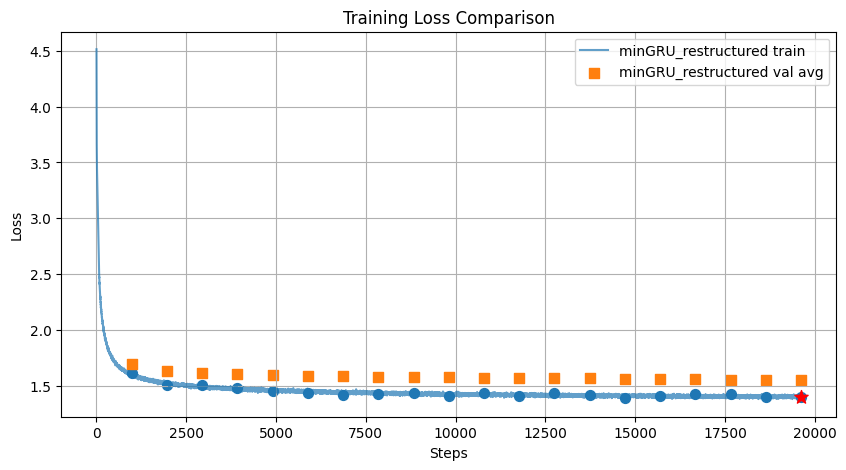

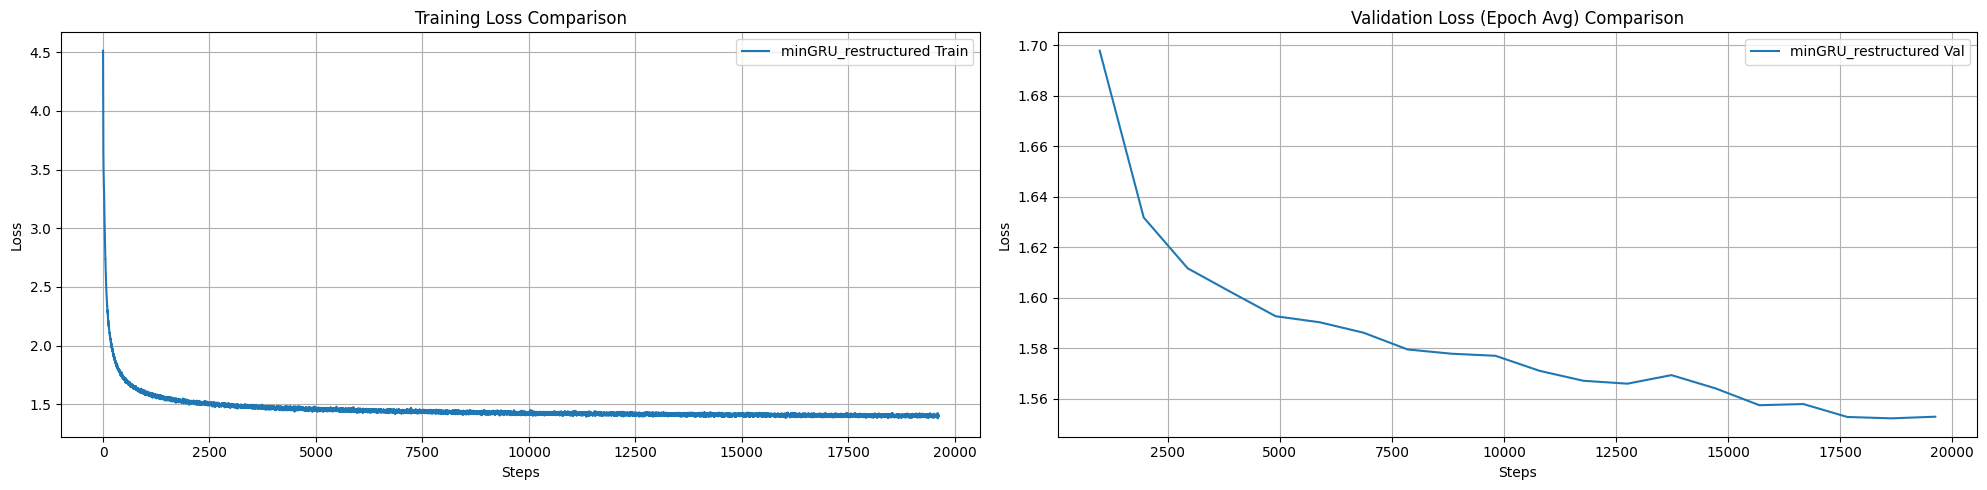

In [26]:
train_and_test("minGRU_restructured", mingru2, start_text)

## Triton minGRU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm

# Triton 라이브러리 임포트
try:
    import triton
    import triton.language as tl
    HAS_TRITON = True
except ImportError:
    HAS_TRITON = False
    print("Triton not found. Please install it to use the optimized GRU implementation.")

@triton.jit
def _softplus(x):
    """
    수치적으로 안정적인 softplus 함수를 Triton으로 구현합니다.
    softplus(x) = log(1 + exp(x))
    """
    return tl.maximum(x, 0.) + tl.log(1. + tl.exp(-tl.abs(x)))


@triton.jit
def _log_add_exp(a, b):
    """ 
    수치적으로 안정적인 log(exp(a) + exp(b)) 계산 
    """
    return tl.maximum(a, b) + tl.log(1. + tl.exp(-tl.abs(a - b)))


@triton.jit
def _log_g(x):
    """ 
    Triton 커널 내에서 사용할 log_g 함수 
    ❗️수치 안정성을 위해 작은 epsilon을 더합니다.
    """
    safe_x = x + 0.5 + 1e-9
    return tl.where(x >= 0, tl.log(safe_x), -_softplus(-x))


@triton.jit
def _gru_scan_op(log_a1, log_b1, log_a2, log_b2):
    """
    GRU 순환 관계를 위한 결합 스캔 연산자입니다.
    """
    new_log_a = log_a1 + log_a2
    new_log_b = _log_add_exp(log_a2 + log_b1, log_b2)
    return new_log_a, new_log_b


@triton.jit
def _parallel_scan_gru_kernel(
    # --- 입력/출력 텐서 포인터 ---
    h_candidate_input_ptr,
    logits_z_ptr,
    output_ptr,
    # --- 텐서 차원 및 스트라이드 ---
    B, L, H,
    stride_h_cand_b, stride_h_cand_l, stride_h_cand_h,
    stride_logits_z_b, stride_logits_z_l, stride_logits_z_h,
    stride_out_b, stride_out_l, stride_out_h,
    # --- 상수 ---
    epsilon: float,
    # --- Triton 메타 파라미터 ---
    BLOCK_SIZE_L: tl.constexpr, 
):
    # --- 프로그램 ID 계산 ---
    pid = tl.program_id(axis=0)
    b_idx = pid // H
    h_idx = pid % H

    # --- 시퀀스(L) 차원에 대한 오프셋 생성 ---
    l_offsets = tl.arange(0, BLOCK_SIZE_L)
    mask = l_offsets < L

    # --- 처리할 전체 시퀀스의 시작 포인터 계산 ---
    h_cand_seq_ptr = h_candidate_input_ptr + (b_idx * stride_h_cand_b + h_idx * stride_h_cand_h + l_offsets * stride_h_cand_l)
    logits_z_seq_ptr = logits_z_ptr + (b_idx * stride_logits_z_b + h_idx * stride_logits_z_h + l_offsets * stride_logits_z_l)
    
    # --- 전역 메모리에서 전체 시퀀스 데이터 로드 ---
    input_dtype = h_candidate_input_ptr.dtype.element_ty
    h_cand_seq = tl.load(h_cand_seq_ptr, mask=mask, other=0.0).to(tl.float32)
    logits_z_seq = tl.load(logits_z_seq_ptr, mask=mask, other=0.0).to(tl.float32)

    # --- 1. 모든 타임스텝에 대한 log_a, log_b 계산 ---
    log_a_seq = -_softplus(logits_z_seq)
    log_b_seq = -_softplus(-logits_z_seq) + _log_g(h_cand_seq)

    # --- 2. 병렬 스캔 수행 ---
    scanned_log_a, scanned_log_b = tl.associative_scan((log_a_seq, log_b_seq), axis=0, combine_fn=_gru_scan_op)

    # --- 3. 초기 은닉 상태(h0) 적용 ---
    log_h0 = tl.log(epsilon)
    log_hidden_states = _log_add_exp(scanned_log_a + log_h0, scanned_log_b)

    # --- 4. 최종 결과 계산 및 저장 ---
    # ❗️ NaN 방지를 위한 클램핑: tl.exp에 들어가기 전, 너무 작은 값(-inf) 방지
    # torch.finfo(dtype).min 값과 유사한 역할을 하는 안전한 최소값 설정
    MIN_LOG_VAL = -30.0 
    log_hidden_states = tl.maximum(log_hidden_states, MIN_LOG_VAL)
    
    output = tl.exp(log_hidden_states)
    output_seq_ptr = output_ptr + (b_idx * stride_out_b + h_idx * stride_out_h + l_offsets * stride_out_l)
    tl.store(output_seq_ptr, output.to(input_dtype), mask=mask)


def _parallel_log_min_gru_triton(
    h_candidate_input: torch.Tensor,
    logits_z: torch.Tensor,
    epsilon: float
) -> torch.Tensor:
    """ Triton 커널을 실행하기 위한 Python 래퍼 함수 """
    B, L, H = h_candidate_input.shape
    device = h_candidate_input.device
    
    output = torch.empty((B, L, H), device=device, dtype=h_candidate_input.dtype) 
    
    # BLOCK_SIZE_L은 L보다 크거나 같은 2의 거듭제곱이어야 함
    BLOCK_SIZE_L = triton.next_power_of_2(L)

    grid = (B * H,)

    _parallel_scan_gru_kernel[grid](
        h_candidate_input, logits_z, output,
        B, L, H,
        h_candidate_input.stride(0), h_candidate_input.stride(1), h_candidate_input.stride(2),
        logits_z.stride(0), logits_z.stride(1), logits_z.stride(2),
        output.stride(0), output.stride(1), output.stride(2),
        epsilon,
        BLOCK_SIZE_L=BLOCK_SIZE_L,
    )
    return output


class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.expansion_factor = expansion_factor
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon
        
        self.use_triton = HAS_TRITON

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)

        if self.use_triton and x.is_cuda and L > 0:
            h_expanded_scan_out = _parallel_log_min_gru_triton(
                h_candidate_input_expanded, 
                logits_z_expanded, 
                self.epsilon
            )
        else:
            if L == 0:
                return torch.empty(B, 0, self.hidden_size, device=x.device, dtype=x.dtype)
            
            log_A = F.logsigmoid(-logits_z_expanded)
            log_Z_expanded = F.logsigmoid(logits_z_expanded)
            log_h_candidate_contrib_expanded = self._original_log_g(h_candidate_input_expanded)
            log_B = log_Z_expanded + log_h_candidate_contrib_expanded

            log_h0_val = torch.full(
                (B, 1, self.internal_expanded_dim),
                math.log(self.epsilon),
                device=x.device,
                dtype=x.dtype
            )
            log_vals = torch.cat([log_h0_val, log_B], dim=1)
            h_expanded_scan_out = self._original_parallel_scan_log(log_A, log_vals)

        output = self.to_out(h_expanded_scan_out)
        return output

    @staticmethod
    def _original_log_g(x: torch.Tensor) -> torch.Tensor:
        return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

    @staticmethod
    def _original_parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
        log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
        terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
        log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1)
        log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
        output_hidden_states = torch.exp(log_hidden_states[:, 1:, :])
        return output_hidden_states

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_dtype = x.dtype
        variance = x.to(torch.float32).pow(2).mean(dim=-1, keepdim=True)
        return (x * torch.rsqrt(variance + self.eps) * self.gamma).to(input_dtype)


class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.dim() == 2:
            x = x.unsqueeze(0)
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2)
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0)
        return x_restored


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False)
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1)
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class minGRULM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1,
        expansion_factor_gru: float = 1.0,
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 2.0,
        conv_kernel_size: int = 3
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        self.conv = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim,
                expansion_factor=ffn_expansion_factor,
                dropout=dropout
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ParallelLogMinGRU( # <--- 최적화된 모듈이 여기서 사용됩니다.
                    input_size=hidden_dim,
                    hidden_size=hidden_dim,
                    expansion_factor=expansion_factor_gru,
                    epsilon=epsilon_gru
                ),
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ffn_layer,
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.to_vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        h = self.embedding(x)
        h = self.input_projection(h)
        h = self.conv(h)

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff)
            h = h_ff_residual_source + h_ff_out
            
            h = dropout_block_output(h)

        h = self.final_norm(h)
        logits = self.to_vocab(h)
        return logits, None


In [28]:
### Model Initialization
mingru4 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [29]:
from torchinfo import summary

summary(mingru4, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 64, 65]            --
├─Embedding: 1-1                         [1024, 64, 32]            2,080
├─Linear: 1-2                            [1024, 64, 76]            2,508
├─CausalDepthWiseConv1d: 1-3             [1024, 64, 76]            --
│    └─Sequential: 2-1                   [1024, 76, 64]            --
│    │    └─Conv1d: 3-1                  [1024, 76, 64]            304
│    │    └─Conv1d: 3-2                  [1024, 76, 64]            5,852
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 64, 76]            76
│    │    └─ParallelLogMinGRU: 3-4       [1024, 64, 76]            11,704
│    │    └─RMSNorm: 3-5                 [1024, 64, 76]            76
│    │    └─SwiGLUFFN: 3-6               [1024, 64, 76]            34,6

Epoch 1/20, Avg Train Loss: 1.9552, Avg Val Loss: 1.7820, Epoch Time: 13.57s, Avg VRAM: 27.63MB


Epoch 2/20, Avg Train Loss: 1.6599, Avg Val Loss: 1.7383, Epoch Time: 14.05s, Avg VRAM: 27.63MB


Epoch 3/20, Avg Train Loss: 1.6216, Avg Val Loss: 1.7197, Epoch Time: 14.00s, Avg VRAM: 27.63MB


Epoch 4/20, Avg Train Loss: 1.6009, Avg Val Loss: 1.7129, Epoch Time: 14.12s, Avg VRAM: 27.63MB


Epoch 5/20, Avg Train Loss: 1.5868, Avg Val Loss: 1.7004, Epoch Time: 13.91s, Avg VRAM: 27.63MB


Epoch 6/20, Avg Train Loss: 1.5776, Avg Val Loss: 1.6938, Epoch Time: 14.14s, Avg VRAM: 27.63MB


Epoch 7/20, Avg Train Loss: 1.5700, Avg Val Loss: 1.6829, Epoch Time: 13.98s, Avg VRAM: 27.63MB


Epoch 8/20, Avg Train Loss: 1.5645, Avg Val Loss: 1.6770, Epoch Time: 14.23s, Avg VRAM: 27.63MB


Epoch 9/20, Avg Train Loss: 1.5597, Avg Val Loss: 1.6762, Epoch Time: 13.95s, Avg VRAM: 27.63MB


Epoch 10/20, Avg Train Loss: 1.5562, Avg Val Loss: 1.6758, Epoch Time: 13.96s, Avg VRAM: 27.63MB


Epoch 11/20, Avg Train Loss: 1.5522, Avg Val Loss: 1.6745, Epoch Time: 14.05s, Avg VRAM: 27.63MB


Epoch 12/20, Avg Train Loss: 1.5491, Avg Val Loss: 1.6726, Epoch Time: 14.19s, Avg VRAM: 27.63MB


Epoch 13/20, Avg Train Loss: 1.5462, Avg Val Loss: 1.6684, Epoch Time: 14.27s, Avg VRAM: 27.63MB


Epoch 14/20, Avg Train Loss: 1.5440, Avg Val Loss: 1.6695, Epoch Time: 14.47s, Avg VRAM: 27.63MB


Epoch 15/20, Avg Train Loss: 1.5419, Avg Val Loss: 1.6651, Epoch Time: 14.59s, Avg VRAM: 27.63MB


Epoch 16/20, Avg Train Loss: 1.5397, Avg Val Loss: 1.6676, Epoch Time: 14.13s, Avg VRAM: 27.63MB


Epoch 17/20, Avg Train Loss: 1.5381, Avg Val Loss: 1.6647, Epoch Time: 14.69s, Avg VRAM: 27.63MB


Epoch 18/20, Avg Train Loss: 1.5363, Avg Val Loss: 1.6660, Epoch Time: 14.91s, Avg VRAM: 27.63MB


Epoch 19/20, Avg Train Loss: 1.5349, Avg Val Loss: 1.6699, Epoch Time: 15.10s, Avg VRAM: 27.63MB


Epoch 20/20, Avg Train Loss: 1.5335, Avg Val Loss: 1.6701, Epoch Time: 16.63s, Avg VRAM: 27.63MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrowdly Montagany, as dishould not that Claudio,
Pary! shall deswein moves as the raise; funther hims on your the king execution, man name: he stright,
Which thinks; but so said I good my enjoy'd off at afflowers for thy champring so me.

HASTINGS:
Cafsels:
By grief evil.

Alt me her world,
Wall we break, pity gatest
Again: if Duke, yet there he's Beth?

AUTOLYCUS:
And lady!

ROMEO:
Roman! it the present:
Thy shall digers
I the year worthy my name of 'wwards. Now, what holes.

FLORIZEL:
Are in thy 


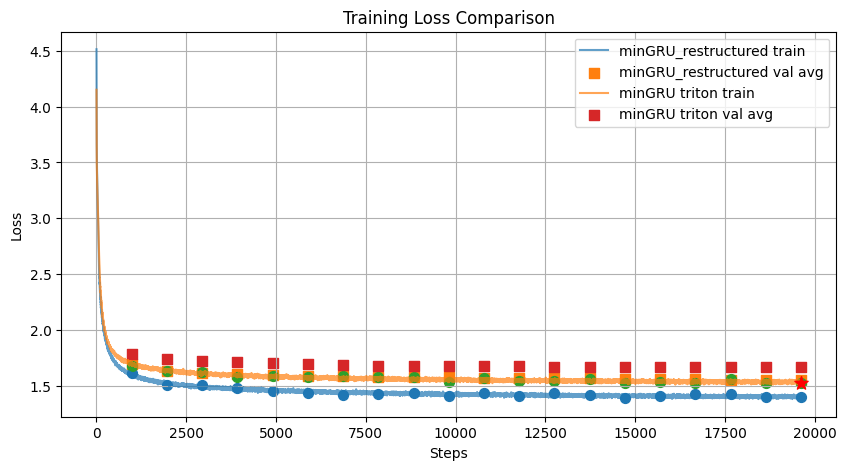

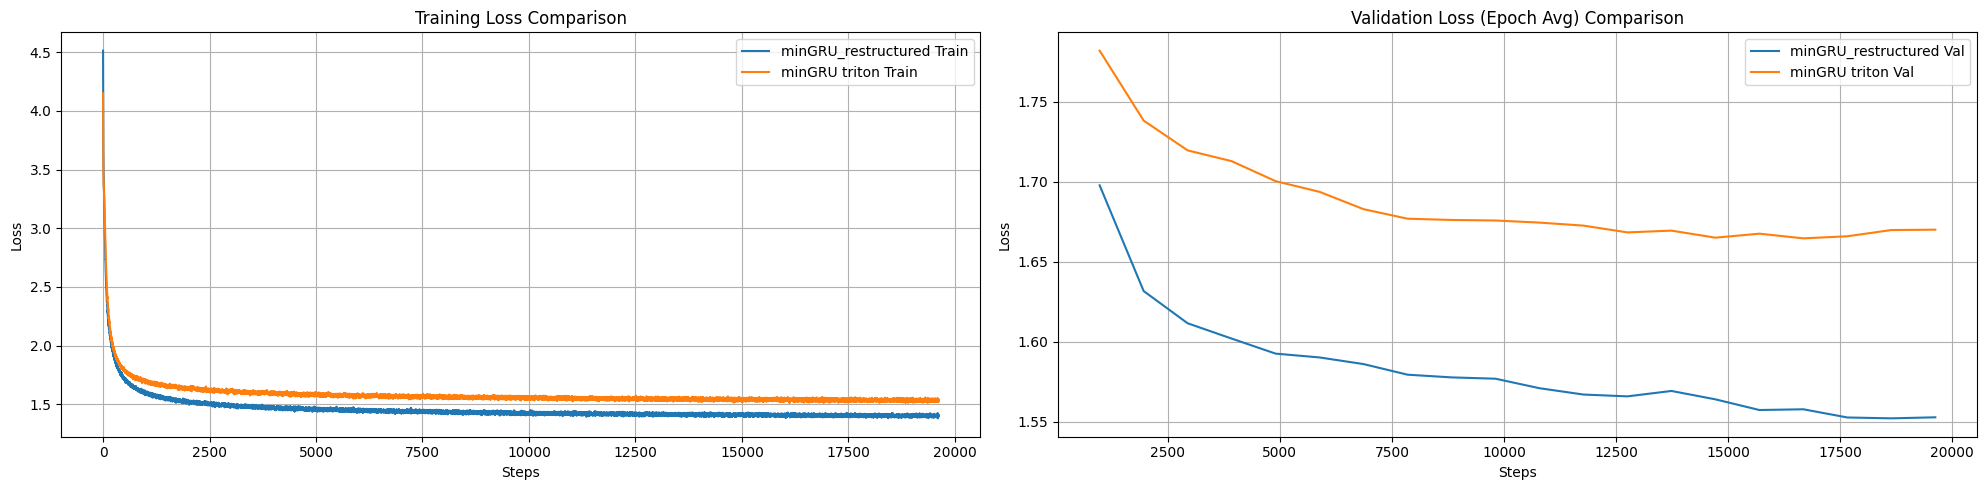

In [30]:
train_and_test("minGRU triton", mingru4, start_text)

## Compiled minGRU with Triton

In [31]:
def train_and_test2(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # 다양한 컴파일 모드:
        # "default": 좋은 성능과 컴파일 시간의 균형
        # "reduce-overhead": 컴파일 오버헤드 감소 (작은 모델에 유리)
        # "max-autotune": 가장 긴 컴파일 시간, 가장 높은 성능 목표
    model = torch.compile(model, mode="reduce-overhead")
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [32]:
### Model Initialization
mingru5 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [33]:
from torchinfo import summary

summary(mingru5, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 64, 65]            --
├─Embedding: 1-1                         [1024, 64, 32]            2,080
├─Linear: 1-2                            [1024, 64, 76]            2,508
├─CausalDepthWiseConv1d: 1-3             [1024, 64, 76]            --
│    └─Sequential: 2-1                   [1024, 76, 64]            --
│    │    └─Conv1d: 3-1                  [1024, 76, 64]            304
│    │    └─Conv1d: 3-2                  [1024, 76, 64]            5,852
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 64, 76]            76
│    │    └─ParallelLogMinGRU: 3-4       [1024, 64, 76]            11,704
│    │    └─RMSNorm: 3-5                 [1024, 64, 76]            76
│    │    └─SwiGLUFFN: 3-6               [1024, 64, 76]            34,6

Epoch 1/20, Avg Train Loss: 2.0309, Avg Val Loss: 1.9070, Epoch Time: 19.07s, Avg VRAM: 3.70MB


Epoch 2/20, Avg Train Loss: 1.7209, Avg Val Loss: 1.9000, Epoch Time: 12.68s, Avg VRAM: 3.70MB


Epoch 3/20, Avg Train Loss: 1.6890, Avg Val Loss: 1.9118, Epoch Time: 10.75s, Avg VRAM: 3.68MB


Epoch 4/20, Avg Train Loss: 1.6745, Avg Val Loss: 1.9225, Epoch Time: 10.69s, Avg VRAM: 3.68MB


Epoch 5/20, Avg Train Loss: 1.6657, Avg Val Loss: 1.9339, Epoch Time: 10.87s, Avg VRAM: 3.68MB


Epoch 6/20, Avg Train Loss: 1.6594, Avg Val Loss: 1.9462, Epoch Time: 10.69s, Avg VRAM: 3.68MB


Epoch 7/20, Avg Train Loss: 1.6547, Avg Val Loss: 1.9448, Epoch Time: 10.50s, Avg VRAM: 3.68MB


Epoch 8/20, Avg Train Loss: 1.6509, Avg Val Loss: 1.9527, Epoch Time: 10.62s, Avg VRAM: 3.68MB


Epoch 9/20, Avg Train Loss: 1.6477, Avg Val Loss: 1.9537, Epoch Time: 10.57s, Avg VRAM: 3.68MB


Epoch 10/20, Avg Train Loss: 1.6453, Avg Val Loss: 1.9655, Epoch Time: 10.37s, Avg VRAM: 3.68MB


Epoch 11/20, Avg Train Loss: 1.6430, Avg Val Loss: 1.9703, Epoch Time: 10.71s, Avg VRAM: 3.68MB


Epoch 12/20, Avg Train Loss: 1.6409, Avg Val Loss: 1.9759, Epoch Time: 10.63s, Avg VRAM: 3.68MB


Epoch 13/20, Avg Train Loss: 1.6393, Avg Val Loss: 1.9808, Epoch Time: 10.58s, Avg VRAM: 3.68MB


Epoch 14/20, Avg Train Loss: 1.6378, Avg Val Loss: 1.9825, Epoch Time: 10.52s, Avg VRAM: 3.68MB


Epoch 15/20, Avg Train Loss: 1.6365, Avg Val Loss: 1.9919, Epoch Time: 10.58s, Avg VRAM: 3.68MB


Epoch 16/20, Avg Train Loss: 1.6353, Avg Val Loss: 1.9974, Epoch Time: 10.65s, Avg VRAM: 3.68MB


Epoch 17/20, Avg Train Loss: 1.6342, Avg Val Loss: 2.0057, Epoch Time: 10.62s, Avg VRAM: 3.68MB


Epoch 18/20, Avg Train Loss: 1.6331, Avg Val Loss: 2.0140, Epoch Time: 10.62s, Avg VRAM: 3.68MB


Epoch 19/20, Avg Train Loss: 1.6322, Avg Val Loss: 2.0198, Epoch Time: 10.65s, Avg VRAM: 3.68MB


Epoch 20/20, Avg Train Loss: 1.6314, Avg Val Loss: 2.0195, Epoch Time: 10.49s, Avg VRAM: 3.68MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morroces. Shams:
Angi.

FORIONeristock towner.
Thcerpone cie, infoy orlest? ad minl, I oforer my; andlence,
By uns is thread hen thous'd an ouse trenge butsiur a
y, my fell my noth's desee.
Yet iorss
Ist theigio suratheme 'till sonellis, the now with bed, for ind thee; ict thouse weet chiencons, butiment I o'dilly. I wish.
He witclecer, noth--ardir vancemt willturent. Was matt'st voeremass late is ty in ofninger int areasteefs.

KINGHAM:
Beilmelane.
Totnescy, buth.
3FS:
Io.

FRIT ronested; wieresacse


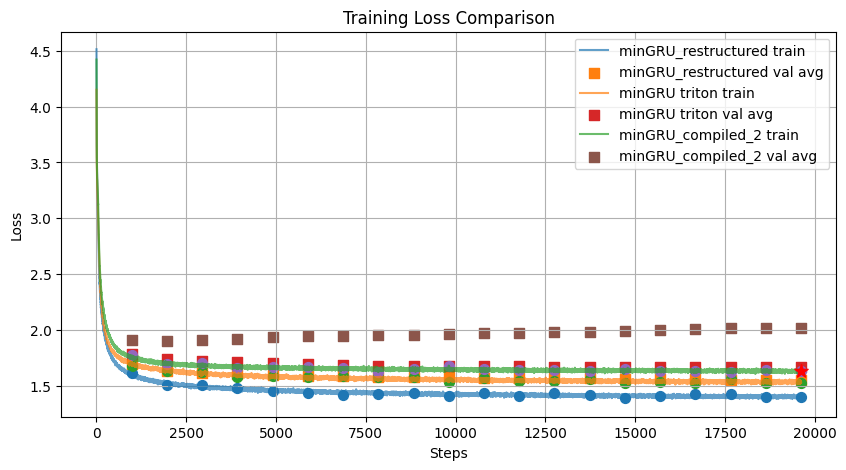

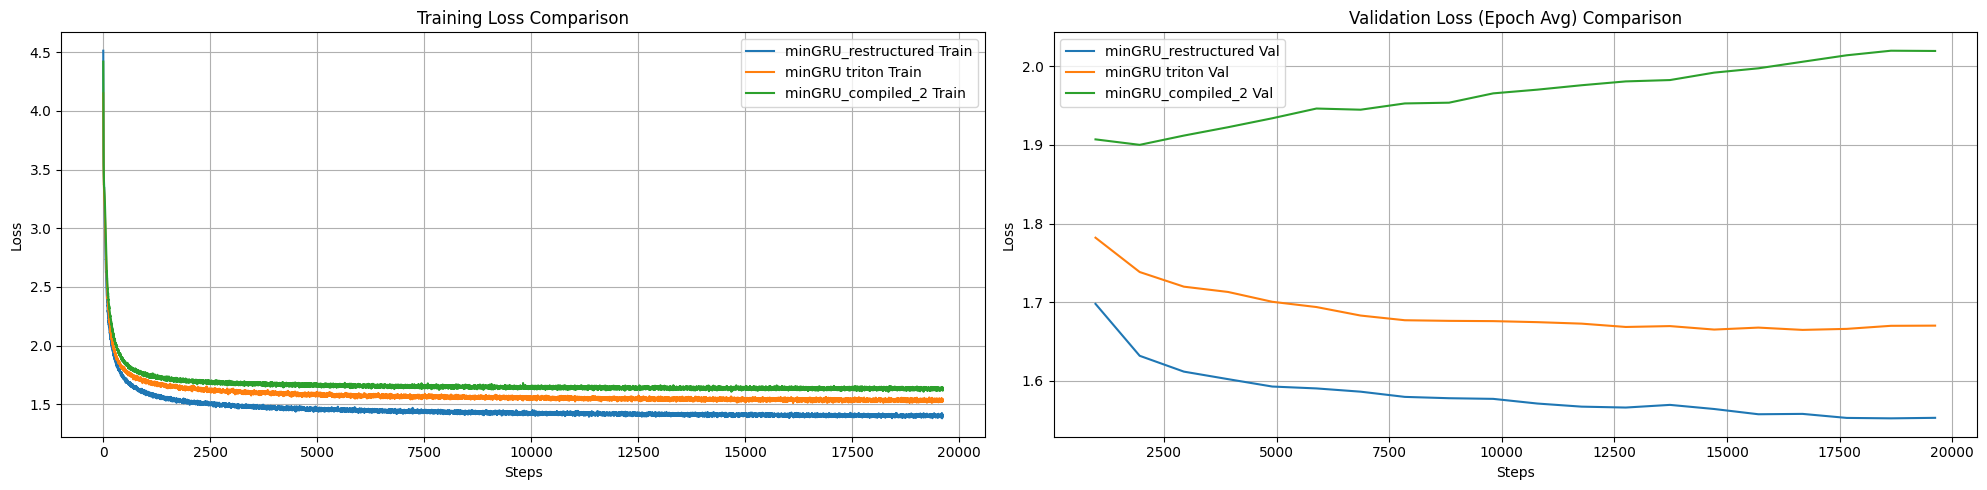

In [34]:
train_and_test2("minGRU_compiled_2", mingru5, start_text)